# Classification Prediction

In [1308]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import pandas as pd
import humanize
from datetime import datetime, timedelta
import time
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [1309]:
CATEGORIES = [1935, 3307, 11000, 260000]

In [1310]:
df = pd.read_csv("training_data.csv")
df = df.drop(columns=df.columns[0])
df.head()
print(len(df))

1567


In [1311]:
def print_score(pred, true):
    print("Mean Squared Error:".ljust(22," "),round(mean_squared_error(true, pred),5))
    print("Mean Absolute Error:".ljust(22," "), round(mean_absolute_error(true, pred),5))
    
def convert(seconds):
    return humanize.naturaldelta(timedelta(seconds=seconds))

def show_diff(predictions,y_test,n=25):
    print("PREDICTION\t RESULT\t\t DIFFERENCE")
    print("-"*45)
    for i in range(0,n):
        print(predictions[i], "\t",y_test[i], "\t", y_test[i] - predictions[i])

def show_plots(predictions, y_test, s=4):
    plt.subplot(211)
    plt.title("Test Results and Predictions")
    plt.scatter(range(len(y_test)),y_test,s=s)
    plt.xlabel("X_test[i]")
    plt.ylabel("correct answer")
    plt.subplot(212)
    plt.scatter(range(len(predictions)),predictions,s=s)
    plt.ylabel("predictions")
    plt.show()

pred = {}
models = {}

## Remove Outliers from DataFrame
any simulations over 26000 seconds is what this just about works out to be

In [1312]:
import pandas as pd
import numpy as np
from scipy import stats

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [1313]:
df.describe()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
count,1442.000000,1442.000000,1442.000000,1442.0,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.0
mean,6396.604022,0.103108,0.400160,1.0,0.459015,0.154201,0.741823,0.087422,0.098965,1.0
std,5750.241251,0.067780,0.201488,0.0,0.222123,0.121748,0.167932,0.055161,0.095449,0.0
min,10.000000,0.041846,0.000000,1.0,0.000000,0.000000,0.250000,0.000000,0.000000,1.0
25%,1935.000000,0.050966,0.272727,1.0,0.305913,0.051458,0.750000,0.045511,0.061078,1.0
50%,3307.000000,0.076433,0.303030,1.0,0.383033,0.144583,0.750000,0.100226,0.061357,1.0
75%,10958.250000,0.128999,0.606061,1.0,0.652956,0.237708,0.833333,0.109813,0.091384,1.0
max,25866.000000,0.309009,0.909091,1.0,1.000000,0.583333,1.000000,0.248807,0.354496,1.0


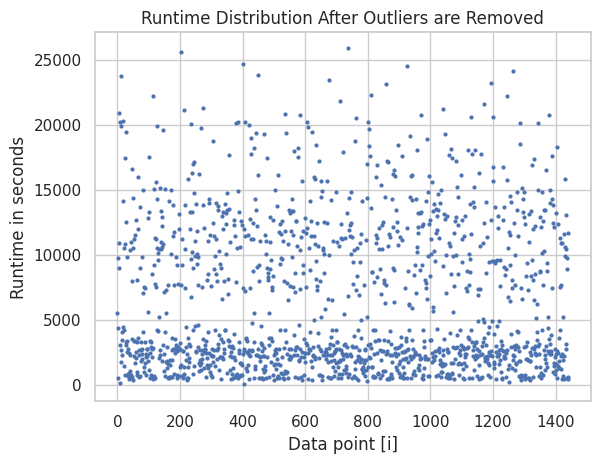

In [1314]:
plt.title("Runtime Distribution After Outliers are Removed")
plt.scatter(range(len(df["runtime"])),df["runtime"],s=4)
plt.ylabel("Runtime in seconds")
plt.xlabel("Data point [i]")
plt.show()

<Axes: xlabel='runtime', ylabel='Count'>

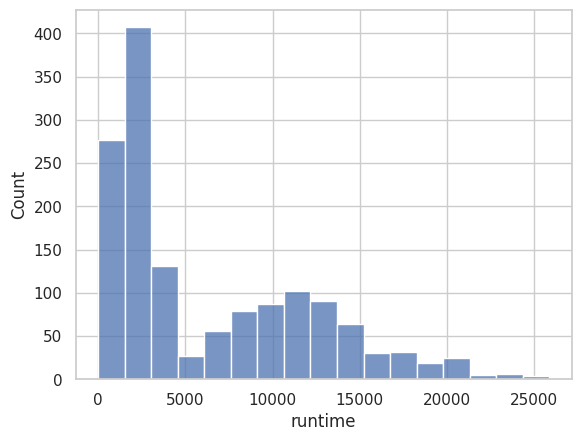

In [1315]:
sns.histplot(df["runtime"])

In [1316]:
for i in [100, 2000, 3300, 11000, 26000]:
    print(f"{convert(i)}")

a minute
33 minutes
55 minutes
3 hours
7 hours


In [1317]:
def categorize(seconds):
    global CATEGORIES
    for i in range(len(CATEGORIES)):
        if (seconds <= CATEGORIES[i]):
            return i

def print_categories():
    global CATEGORIES
    for i in range(len(CATEGORIES)):
        print(f"{convert(CATEGORIES[i])}   \t{i}")

In [1318]:
runtime_categories = df.apply(lambda row: categorize(row["runtime"]), axis=1)
# df.insert(0, "runtime_ca", runtime_categories)
df["runtime_ca"] = runtime_categories
df.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire,runtime_ca
0,5475,0.050966,0.303030,1.0,0.241645,0.051458,0.833333,0.074582,0.046235,1.0,2
1,9737,0.128999,0.151515,1.0,0.305913,0.144583,0.750000,0.100625,0.293084,1.0,2
2,501,0.044546,0.363636,1.0,0.768638,0.051458,0.791667,0.005656,0.011231,1.0,0
3,4325,0.055708,0.303030,1.0,0.426735,0.083333,0.916667,0.099840,0.131749,1.0,2
4,9008,0.170005,0.454545,1.0,1.000000,0.144583,0.833333,0.171107,0.061357,1.0,2


32 minutes 	 0
55 minutes 	 1
3 hours 	 2
3 days 	 3


runtime_ca
2    364
0    361
1    360
3    357
Name: count, dtype: int64

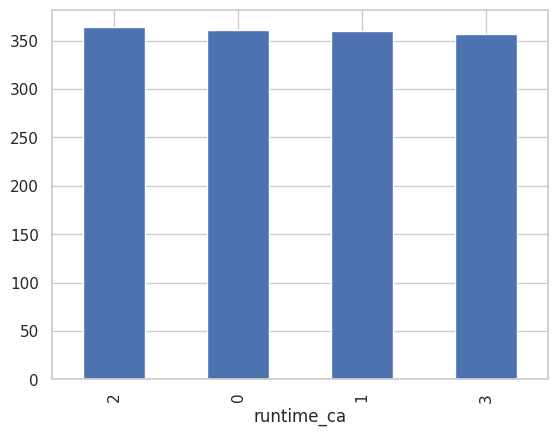

In [1319]:
for i in range(len(CATEGORIES)):
    print(convert(CATEGORIES[i]),"\t",i)
df["runtime_ca"].value_counts().plot(kind="bar")
df["runtime_ca"].value_counts()


In [1320]:
y = df["runtime_ca"]
X = df.drop(columns=["runtime","runtime_ca"])
X.tail()

,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
1562,0.045317,0.303030,1.0,0.228792,0.051458,0.750000,0.000000,0.000000,1.0
1563,0.128738,0.151515,1.0,0.460154,0.125958,0.833333,0.100649,0.293084,1.0
1564,0.044546,0.212121,1.0,0.691517,0.051458,0.791667,0.005659,0.011231,1.0
1565,0.309009,0.454545,1.0,0.228792,0.144583,0.750000,0.171151,0.061357,1.0
1566,0.045317,0.303030,1.0,0.305913,0.051458,0.750000,0.000155,0.000000,1.0


In [1321]:
TEST_RATIO = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO,random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(len(X_train), len(X_test), len(y_train), len(y_test))

1153 289 1153 289


# Classification Approaches
- K Means clustering
- SVM
- decision tree
  

# K Means Clustering

In [1322]:
from sklearn.cluster import KMeans

# ------ experiment with cluster amount ---------- #
n_clusters = len(CATEGORIES)
# ------ experiment with cluster amount ---------- #

model = KMeans(n_clusters=n_clusters, n_init=10)
model = model.fit(X_train,y_train)

In [1323]:
pred["Kmeans"] = model.predict(X_test)
models["Kmeans"] = model

In [1324]:
print_score(pred["Kmeans"], y_test)

Mean Squared Error:    2.34256
Mean Absolute Error:   1.29066


In [1325]:
accuracy_score(y_true=y_test,y_pred=pred["Kmeans"])

0.1522491349480969

15% is very bad accuracy, something must be wrong with my approach to using K means here but I am not sure so I will try another model. Could be an input data problem but I am skeptical of that

# SVM

In [1326]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
model = model.fit(X_train,y_train)

In [1327]:
pred["SVM"] = model.predict(X_test)
models["SVM"] = model
accuracy_score(y_true=y_test,y_pred=pred["SVM"])

0.6539792387543253

# Decision Tree Classifier

In [1328]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model = model.fit(X_train, y_train)

In [1329]:
pred["DecisionTree"] = model.predict(X_test)
models["DecisionTree"] = model
accuracy_score(y_true=y_test,y_pred=pred["DecisionTree"])

0.657439446366782

# Logistic Regression

currently not working

In [1330]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=400)
model = model.fit(X_train, y_train)

In [1331]:
pred["LogisticRegression"] = model.predict(X_test)
models["LogisticRegression"] = model
accuracy_score(y_true=y_test,y_pred=pred["LogisticRegression"])

0.5813148788927336

# Stochastic Gradient Descent

In [1332]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
model = model.fit(X_train, y_train)

In [1333]:
pred["SGD"] = model.predict(X_test)
models["SGD"] = model
accuracy_score(y_true=y_test,y_pred=pred["SGD"])

0.657439446366782

# K Nearest Neighbor

In [1334]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=len(CATEGORIES))
model = model.fit(X_train, y_train)

In [1335]:
pred["kNN"] = model.predict(X_test)
models["kNN"] = model
accuracy_score(y_true=y_test,y_pred=pred["kNN"])

0.6505190311418685

# Random Forest


In [1336]:
from sklearn.ensemble import RandomForestClassifier
# ----------------- #
n = 35
# ----------------- #
model = RandomForestClassifier(n_estimators=n)
model = model.fit(X_train, y_train)

In [1337]:
pred["RandomForest"] = model.predict(X_test)
models["RandomForest"] = model
accuracy_score(y_true=y_test,y_pred=pred["RandomForest"])

0.7093425605536332

# Gradient Boosting

In [1338]:
from sklearn.ensemble import GradientBoostingClassifier
# ----------------- #
n = 35
# ----------------- #

model = GradientBoostingClassifier(max_depth=3, learning_rate=0.1, n_estimators = n)
model = model.fit(X_train, y_train)

In [1339]:
pred["GradientBoosting"] = model.predict(X_test)
models["GradientBoosting"] = model

accuracy_score(y_true=y_test,y_pred=pred["GradientBoosting"])

0.726643598615917

# LGBM

In [1340]:
# !pip3 install --user lightgbm

In [1341]:
from lightgbm import LGBMClassifier
# ----------------- #
n = 100
# ----------------- #
model = LGBMClassifier(n_estimators = n)
model = model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 1153, number of used features: 7
[LightGBM] [Info] Start training from score -1.359763
[LightGBM] [Info] Start training from score -1.418911
[LightGBM] [Info] Start training from score -1.376799
[LightGBM] [Info] Start training from score -1.390640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [1342]:
pred["LGBM"] = model.predict(X_test)
models["LGBM"] = model

accuracy_score(y_true=y_test,y_pred=pred["LGBM"])

0.6851211072664359

# XGB

In [1343]:
# !pip3 install --user xgboost

In [1344]:
from xgboost.sklearn import XGBClassifier
# ----------------- #
n = 100
# ----------------- #
model = XGBClassifier(n_estimators = n)
model = model.fit(X_train, y_train)

In [1345]:
pred["XGB"] = model.predict(X_test)
models["XGB"] = model

accuracy_score(y_true=y_test,y_pred=pred["XGB"])

0.6851211072664359

# GBRT ensemble
from page 200 of Hands on Machine learning with sklearn and tensorflow

In [1346]:
model = GradientBoostingClassifier(max_depth=2, n_estimators=120)
model.fit(X_train,y_train)

errors = [accuracy_score(y_true=y_test, y_pred=y_pred) for y_pred in model.staged_predict(X_test)]
bst_n_estimators = np.argmax(errors)

grbt_best = GradientBoostingClassifier(max_depth=2, n_estimators=bst_n_estimators)
grbt_best.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=37)

In [1347]:
pred["GRBT"] = model.predict(X_test)
models["GRBT"] = model

accuracy_score(y_true=y_test,y_pred=pred["GRBT"])

0.71280276816609

# Ensemble Learning
voting classifier to predict based on votes from multiple previous classifiers

In [1348]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators = [
        ('svc',models['SVM']),
        ('lr',models['LogisticRegression']),
        ('rf',models['RandomForest']),
        ('kNN',models['kNN']),
        ('dt',models['DecisionTree']),
        ('sgd',models['SGD']),
        ('XGB',models['XGB']),
        ('gradient',models['GradientBoosting'])
    ],
    voting='hard'
)
voting_clf

VotingClassifier(estimators=[('svc', SVC()),
                             ('lr', LogisticRegression(max_iter=400)),
                             ('rf', RandomForestClassifier(n_estimators=35)),
                             ('kNN', KNeighborsClassifier(n_neighbors=4)),
                             ('dt', DecisionTreeClassifier()),
                             ('sgd', SGDClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob',
                                            predictor=None, ...)),
                             ('gradient',
                              GradientBoostingClassifier(n_estimators=35))])

In [1349]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('svc', SVC()),
                             ('lr', LogisticRegression(max_iter=400)),
                             ('rf', RandomForestClassifier(n_estimators=35)),
                             ('kNN', KNeighborsClassifier(n_neighbors=4)),
                             ('dt', DecisionTreeClassifier()),
                             ('sgd', SGDClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob',
                                            predictor=None, ...)),
                             ('gradient',
                              GradientBoostingClassifier(n_estimators=35))])

In [1350]:
pred["voting"] = voting_clf.predict(X_test)
# models["voting"] = model

accuracy_score(y_true=y_test,y_pred=pred["voting"])

0.71280276816609

# Compare Models

In [1351]:
# compare = pd.DataFrame(pred)
compare = pd.DataFrame({
    "name":pred.keys(), 
    "accuracy":np.nan,
    "mse":np.nan,
})
compare = compare.set_index("name")

In [1352]:
compare["accuracy"] = compare.apply(lambda row: accuracy_score(y_pred=pred[row.name],y_true=y_test)*100,axis=1)
compare["mse"] = compare.apply(lambda row: mean_squared_error(y_pred=pred[row.name],y_true=y_test),axis=1)
compare["mean absolute"] = compare.apply(lambda row: mean_absolute_error(y_pred=pred[row.name],y_true=y_test),axis=1)

### So how do the models stack up to each other?

In [1353]:
compare

,accuracy,mse,mean absolute
name,,,
Kmeans,15.224913,2.342561,1.290657
SVM,65.397924,0.377163,0.356401
DecisionTree,65.743945,0.432526,0.370242
LogisticRegression,58.131488,0.501730,0.446367
SGD,65.743945,0.363322,0.349481
kNN,65.051903,0.435986,0.373702
RandomForest,70.934256,0.349481,0.307958
GradientBoosting,72.664360,0.301038,0.280277
LGBM,68.512111,0.384083,0.335640


so Kmeans is pretty bad, Random Forest, Gradient Boosting and GRBT appear to be the best

the voting ensemble also does well, just about matching the performance of any one other model. I hoped it would exceed the individuals but it has not yet

In [1354]:
print_categories()

32 minutes   	0
55 minutes   	1
3 hours   	2
3 days   	3


note: look into principal component analysis

# Charts in progress

In [922]:
a = pd.Series(pred["LGBM"]).value_counts()
b = pd.Series(y_test).value_counts()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male


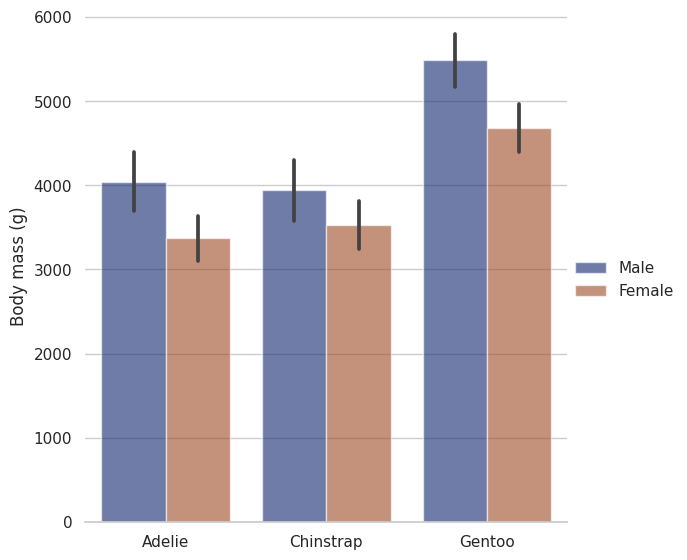

In [923]:
sns.set_theme(style="whitegrid")

penguins = sns.load_dataset("penguins")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=penguins, kind="bar",
    x="species", y="body_mass_g", hue="sex",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")
penguins.tail(5)

In [924]:
model_val_counts = pd.Series(pred["XGB"]).value_counts()
y_test_val_counts = pd.Series(y_test).value_counts()
c = dict(model_val_counts)
d = dict(y_test_val_counts)

merged_dict = {}
for i in range(0,len(c)):
    merged_dict[i] = [c[i], d[i]]

data = pd.DataFrame(merged_dict)
# data["hue"] = [0,1]
data = data.T

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male


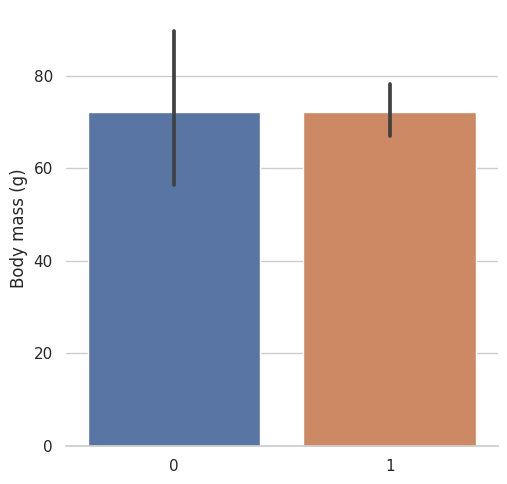

In [758]:
sns.set_theme(style="whitegrid")

penguins = sns.load_dataset("penguins")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=data, kind="bar"
    # x="species", y="body_mass_g", hue="sex",
    # errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
# g.legend.set_title("")
penguins.tail(5)


In [759]:
data

,0,1
0,62,65
1,99,81
2,51,73
3,77,70
